### Libraries

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import Pipeline
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier


### Unzipping

In [22]:

# Define paths
zip_path = '/workspaces/Isabell-Joane-Eric-Final-Project/src/DontGetKicked.zip'
extract_to = '/workspaces/Isabell-Joane-Eric-Final-Project/data/processed'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/Isabell-Joane-Eric-Final-Project/src/DontGetKicked.zip'

In [3]:
# Load the data
total_data = pd.read_csv(f'{extract_to}/training.csv')

total_data.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


### Coversions + Removals

In [4]:

# Convert WheelTypeID to 'category'
total_data['WheelTypeID'] = total_data['WheelTypeID'].astype('category')

# Group zip codes by the first two digits into a new column 'ZipRegion'
total_data['ZipRegion'] = total_data['VNZIP1'].astype(str).str[:2]

# Remove specified columns
columns_to_remove = ["AUCGUART", "PRIMEUNIT", "VNST", "VNZIP1", "BYRNO", "PurchDate", "RefId", "SubModel", "Color", "WheelType"]
total_data.drop(columns=columns_to_remove, axis=1, inplace=True)



### Defining cols

In [5]:
# Define categorical and numerical columns
categorical_columns = [
    'Auction', 'Transmission', 'WheelTypeID', 'Nationality', 'TopThreeAmericanName', 'IsOnlineSale', 'Size', 'ZipRegion'
]

numerical_columns = [
    'VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
    'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost',
    'WarrantyCost'
]

# Ensure categorical columns are of type 'str'
for column in categorical_columns:
    total_data[column] = total_data[column].astype(str)

# Ensure numerical columns are of type 'float'
for column in numerical_columns:
    total_data[column] = total_data[column].astype(float)

# Define feature sets for PCA
currentauction_features = [
    "MMRCurrentAuctionAveragePrice", "MMRCurrentAuctionCleanPrice", "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice"
]
acquisitionauction_features = [
    "MMRAcquisitionAuctionAveragePrice", "MMRAcquisitionAuctionCleanPrice", "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice"
]
remaining_features = [
    'Auction', 'VehYear', 'VehicleAge', 'Make', 'Model', 'Trim', 'Transmission', 'WheelTypeID', 'VehOdo', 'Nationality', 
    'Size', 'TopThreeAmericanName', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'ZipRegion'
]

### Data Split

In [6]:

# Split the data into training and testing sets
X = total_data[remaining_features + currentauction_features + acquisitionauction_features]
y = total_data['IsBadBuy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



### Pipelines

In [7]:
# Define transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['VehYear', 'VehicleAge', 'VehOdo',
                                  'MMRAcquisitionAuctionAveragePrice',
                                  'MMRAcquisitionAuctionCleanPrice',
                                  'MMRAcquisitionRetailAveragePrice',
                                  'MMRAcquisitonRetailCleanPrice',
                                  'MMRCurrentAuctionAveragePrice',
                                  'MMRCurrentAuction...ice',
                                  'MMRCurrentRetailAveragePrice',
                                  'MMRCurrentRetailCleanPrice', 'VehBCost',
                                  'WarrantyCost']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Auction', 'Transmission', 'WheelTypeID',
                                  'Nationality', 'TopThreeAmericanName',
                                  'IsOnlineSale', 'Size', 'ZipRegion'])])

In [8]:

# Create a pipeline with SMOTE and KNN
pipeline_knn_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('knn', KNeighborsClassifier())
])

pipeline_knn_smote

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['VehYear', 'VehicleAge',
                                                   'VehOdo',
                                                   'MMRAcquisitionAuctionAveragePrice',
                                                   'MMRAcquisitionAuctionCleanPrice',
                                                   'MMRAcquisitionRetailAveragePrice',
                                                   'MMRAcquisitonRetailCleanPrice',
                                                   'MMRCurrentAuction...
                                                   'WarrantyCost']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Auction', 'Transmission',
                                                   'WheelTypeID', 'Nationality',
                                                   'TopThreeAmericanName',
                                                   'IsOnlineSale', 'Size',
                                                   'ZipRegion'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
                ('knn', KNeighborsClassifier())])

### Random Grid (KNN + SMOTE)

In [20]:
# Define smaller parameter grids
param_grid_chunk1 = {
    'knn__n_neighbors': [3, 5],
    'knn__weights': ['uniform'],
    'knn__metric': ['euclidean']
}

param_grid_chunk2 = {
    'knn__n_neighbors': [7, 9],
    'knn__weights': ['distance'],
    'knn__metric': ['manhattan']
}

param_grid_chunk3 = {
    'knn__n_neighbors': [11, 13],
    'knn__weights': ['uniform'],
    'knn__metric': ['minkowski']
}

param_grid_chunk4 = {
    'knn__n_neighbors': [15, 17],
    'knn__weights': ['distance'],
    'knn__metric': ['euclidean']
}

# Function to run RandomizedSearchCV on a parameter grid chunk
def run_search(param_grid, X_train, y_train):
    random_search = RandomizedSearchCV(pipeline_knn_smote, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search

results = []

for param_grid in [param_grid_chunk1, param_grid_chunk2, param_grid_chunk3, param_grid_chunk4]:
    search_result = run_search(param_grid, X_train, y_train)
    results.append(search_result)
    print(f"Completed search with parameters: {param_grid}")

# Print best parameters, best score, and classification report for each search result
for i, result in enumerate(results):
    best_params = result.best_params_
    best_score = result.best_score_
    best_estimator = result.best_estimator_
    
    # Predict on the test set using the best model from each search
    y_pred_best = best_estimator.predict(X_test)
    
    # Generate classification report
    report = classification_report(y_test, y_pred_best)
    
    # Print results
    print(f"Results for param grid chunk {i + 1}:")
    print(f"Best Parameters: {best_params}")
    print(f"Best cross-validation accuracy: {best_score}")
    print("Classification Report:")
    print(report)
    print("\n")


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed search with parameters: {'knn__n_neighbors': [3, 5], 'knn__weights': ['uniform'], 'knn__metric': ['euclidean']}


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed search with parameters: {'knn__n_neighbors': [7, 9], 'knn__weights': ['distance'], 'knn__metric': ['manhattan']}


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed search with parameters: {'knn__n_neighbors': [11, 13], 'knn__weights': ['uniform'], 'knn__metric': ['minkowski']}


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed search with parameters: {'knn__n_neighbors': [15, 17], 'knn__weights': ['distance'], 'knn__metric': ['euclidean']}
Results for param grid chunk 1:
Best Parameters: {'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean'}
Best cross-validation accuracy: 0.847823108279382
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     12802
           1       0.35      0.27      0.30      1795

    accuracy                           0.85     14597
   macro avg       0.63      0.60      0.61     14597
weighted avg       0.83      0.85      0.84     14597



Results for param grid chunk 2:
Best Parameters: {'knn__weights': 'distance', 'knn__n_neighbors': 9, 'knn__metric': 'manhattan'}
Best cross-validation accuracy: 0.8852807179803378
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     12802
           1       0.64      0.13

In [21]:

# Define smaller parameter grids
param_grid_chunk1 = {
    'knn__n_neighbors': [1, 3, 5],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__leaf_size': [20, 30, 40]
}

param_grid_chunk2 = {
    'knn__n_neighbors': [7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski'],
    'knn__p': [1, 2],
    'knn__leaf_size': [20, 30, 40]
}

param_grid_chunk3 = {
    'knn__n_neighbors': [13, 15, 17],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['chebyshev', 'euclidean'],
    'knn__leaf_size': [20, 30, 40]
}

param_grid_chunk4 = {
    'knn__n_neighbors': [19, 21, 23],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['manhattan', 'minkowski'],
    'knn__p': [1, 2],
    'knn__leaf_size': [20, 30, 40]
}

# Function to run RandomizedSearchCV on a parameter grid chunk
def run_search(param_grid, X_train, y_train):
    random_search = RandomizedSearchCV(pipeline_knn_smote, param_distributions=param_grid, n_iter=10, cv=3, scoring='recall', n_jobs=1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search

results = []

for param_grid in [param_grid_chunk1, param_grid_chunk2, param_grid_chunk3, param_grid_chunk4]:
    search_result = run_search(param_grid, X_train, y_train)
    results.append(search_result)
    print(f"Completed search with parameters: {param_grid}")
    # Print classification report for each chunk
    y_pred = search_result.predict(X_test)
    print(f"Classification Report for parameters: {param_grid}")
    print(classification_report(y_test, y_pred))

# Combine results to find the best model
best_params = None
best_score = -np.inf

for result in results:
    if result.best_score_ > best_score:
        best_score = result.best_score_
        best_params = result.best_params_

print("Best Parameters found: ", best_params)
print("Best cross-validation recall: ", best_score)

# Predict on the test set using the best model from RandomizedSearchCV
best_model = results[0].best_estimator_
y_pred_best = best_model.predict(X_test)

# Generate classification report for the best model
print("Classification Report for the best model:")
print(classification_report(y_test, y_pred_best))


Completed search with parameters: {'knn__n_neighbors': [1, 3, 5], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['euclidean', 'manhattan'], 'knn__leaf_size': [20, 30, 40]}
Classification Report for parameters: {'knn__n_neighbors': [1, 3, 5], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['euclidean', 'manhattan'], 'knn__leaf_size': [20, 30, 40]}
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     12802
           1       0.28      0.30      0.29      1795

    accuracy                           0.82     14597
   macro avg       0.59      0.60      0.59     14597
weighted avg       0.82      0.82      0.82     14597

Completed search with parameters: {'knn__n_neighbors': [7, 9, 11], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['minkowski'], 'knn__p': [1, 2], 'knn__leaf_size': [20, 30, 40]}
Classification Report for parameters: {'knn__n_neighbors': [7, 9, 11], 'knn__weights': ['uniform', 'distance'], 'knn_

/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/vscode/.local/lib/python3.10/site-packages/imblearn/pipeline.py", line 326, in fit
    self._final_estimator.fit(Xt, yt, **last_step_para

Completed search with parameters: {'knn__n_neighbors': [13, 15, 17], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['chebyshev', 'euclidean'], 'knn__leaf_size': [20, 30, 40]}
Classification Report for parameters: {'knn__n_neighbors': [13, 15, 17], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['chebyshev', 'euclidean'], 'knn__leaf_size': [20, 30, 40]}
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     12802
           1       0.49      0.20      0.28      1795

    accuracy                           0.88     14597
   macro avg       0.69      0.58      0.61     14597
weighted avg       0.85      0.88      0.85     14597

Completed search with parameters: {'knn__n_neighbors': [19, 21, 23], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['manhattan', 'minkowski'], 'knn__p': [1, 2], 'knn__leaf_size': [20, 30, 40]}
Classification Report for parameters: {'knn__n_neighbors': [19, 21, 23], 'knn__weights': ['unifo

### Best KNN

In [22]:
# Print the best KNN model found from the previous grid searches
print("Best KNN Model Parameters: ", best_params)


Best KNN Model Parameters:  {'knn__weights': 'distance', 'knn__n_neighbors': 1, 'knn__metric': 'euclidean', 'knn__leaf_size': 30}


### Stacking with XGBoost

In [34]:

# Define the function to convert sparse matrix to dense and then to a numpy array
def sparse_to_dense(X):
    return np.asarray(X.todense())

# Preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Define the best KNN model found from the previous grid searches
best_knn = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='euclidean', leaf_size=30)

# Define the XGBoost classifier with categorical feature support enabled
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)

# Create the stacking classifier with KNN and XGBoost
stacking_classifier = StackingClassifier(
    estimators=[
        ('knn', best_knn),
        ('xgb', xgb)
    ],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True),
    passthrough=True,
    cv=3
)

# Use ImbPipeline from imbalanced-learn
stacking_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('to_dense', FunctionTransformer(sparse_to_dense, accept_sparse=True)),
    ('stacking', stacking_classifier)
])

# Use cross_val_predict to generate out-of-fold predictions for stacking with limited parallel jobs
oof_predictions = cross_val_predict(stacking_pipeline, X_train, y_train, cv=3, method='predict', n_jobs=2)

# Fit the stacking pipeline on the entire training data
stacking_pipeline.fit(X_train, y_train)

# Predict on the test set using the stacking classifier
y_pred_stacking = stacking_pipeline.predict(X_test)

# Generate classification report for the stacking classifier
print("Classification Report for the stacking classifier:")
print(classification_report(y_test, y_pred_stacking))


Classification Report for the stacking classifier:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12802
           1       0.67      0.25      0.37      1795

    accuracy                           0.89     14597
   macro avg       0.79      0.62      0.65     14597
weighted avg       0.88      0.89      0.87     14597



### Comparison of Model Performance Metrics

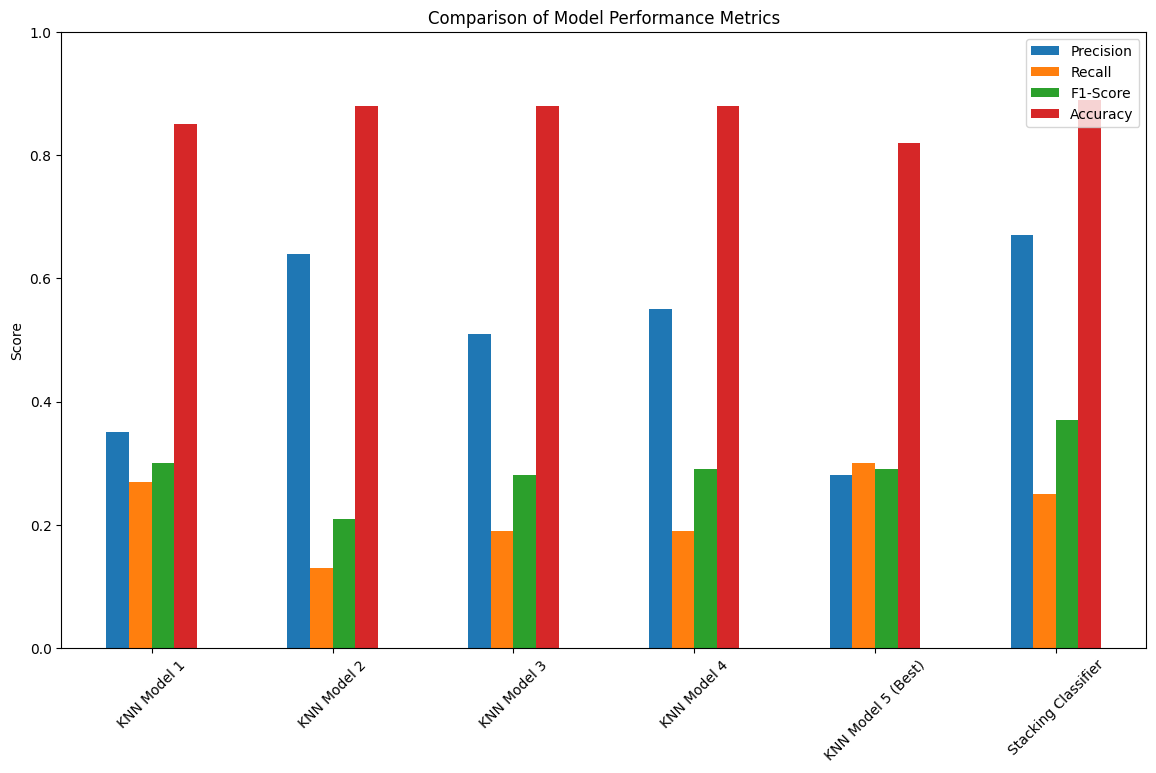

In [21]:

# Confusion Matrices
cm_knn_1 = np.array([[11354, 1448], [1256, 539]])
cm_knn_2 = np.array([[12674, 128], [1561, 234]])
cm_knn_3 = np.array([[12418, 384], [1451, 344]])
cm_knn_4 = np.array([[12546, 256], [1455, 340]])
cm_knn_5 = np.array([[11354, 1448], [1256, 539]])
cm_stacking = np.array([[12546, 256], [1346, 449]])


# Comparison Bar Plot
metrics = {
    'KNN Model 1': {
        'Precision': 0.35,
        'Recall': 0.27,
        'F1-Score': 0.30,
        'Accuracy': 0.85
    },
    'KNN Model 2': {
        'Precision': 0.64,
        'Recall': 0.13,
        'F1-Score': 0.21,
        'Accuracy': 0.88
    },
    'KNN Model 3': {
        'Precision': 0.51,
        'Recall': 0.19,
        'F1-Score': 0.28,
        'Accuracy': 0.88
    },
    'KNN Model 4': {
        'Precision': 0.55,
        'Recall': 0.19,
        'F1-Score': 0.29,
        'Accuracy': 0.88
    },
    'KNN Model 5 (Best)': {
        'Precision': 0.28,
        'Recall': 0.30,
        'F1-Score': 0.29,
        'Accuracy': 0.82
    },
    'Stacking Classifier': {
        'Precision': 0.67,
        'Recall': 0.25,
        'F1-Score': 0.37,
        'Accuracy': 0.89
    }
}

metrics_df = pd.DataFrame(metrics).T

metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


### Best KNN vs Stacking XGBoost

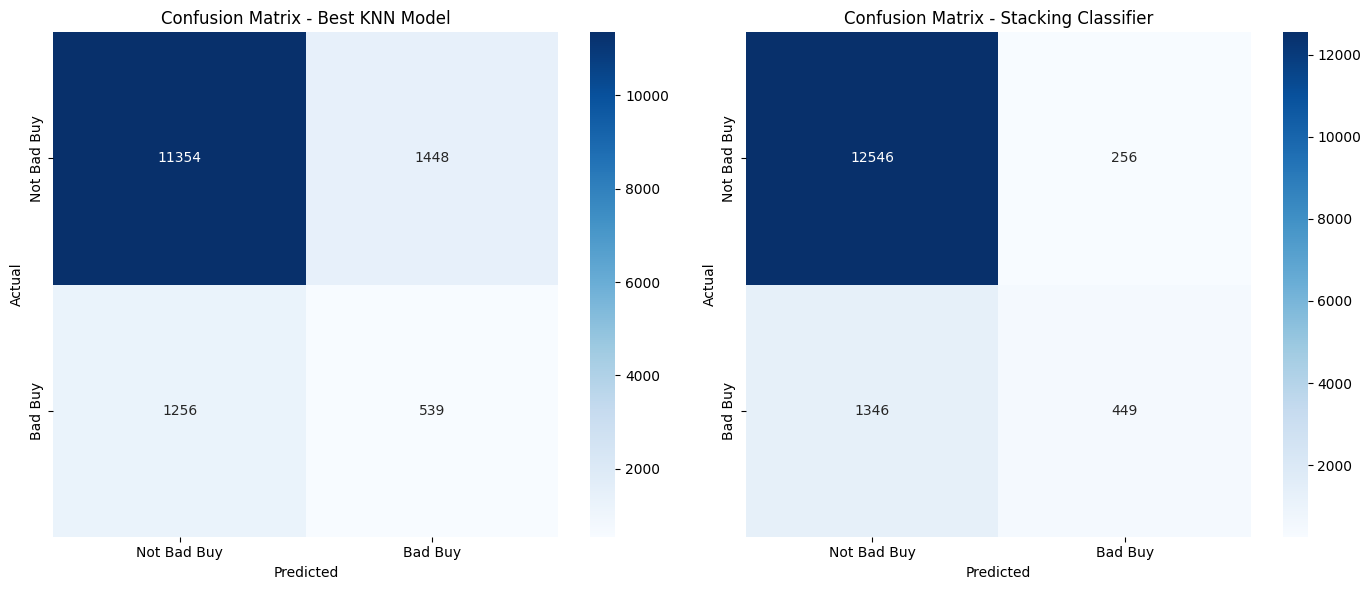

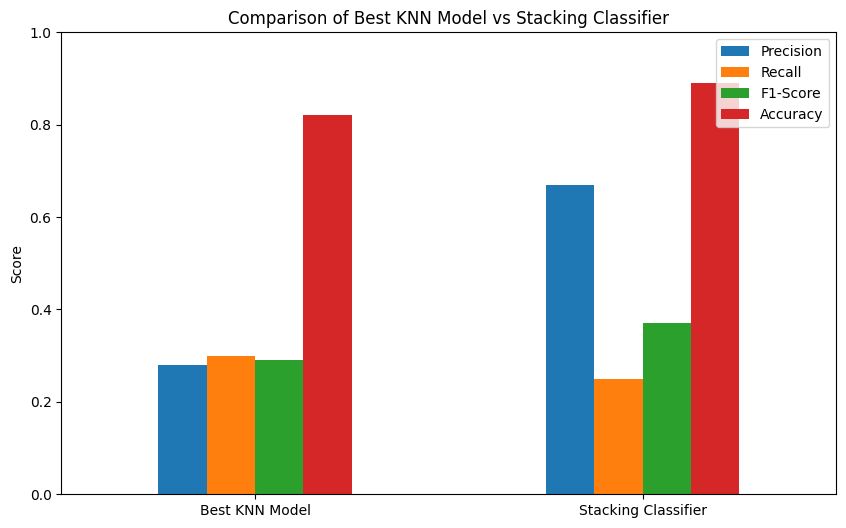

In [11]:

# Confusion Matrices
cm_best_knn = np.array([[11354, 1448], [1256, 539]])
cm_stacking = np.array([[12546, 256], [1346, 449]])

# Comparison Bar Plot for Best KNN Model vs Stacking Classifier
metrics = {
  'Best KNN Model': {
      'Precision': 0.28,
      'Recall': 0.30,
      'F1-Score': 0.29,
      'Accuracy': 0.82
  },
  'Stacking Classifier': {
      'Precision': 0.67,
      'Recall': 0.25,
      'F1-Score': 0.37,
      'Accuracy': 0.89
  }
}

metrics_df = pd.DataFrame(metrics).T

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Best KNN Model vs Stacking Classifier')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()


### ROC Comparison

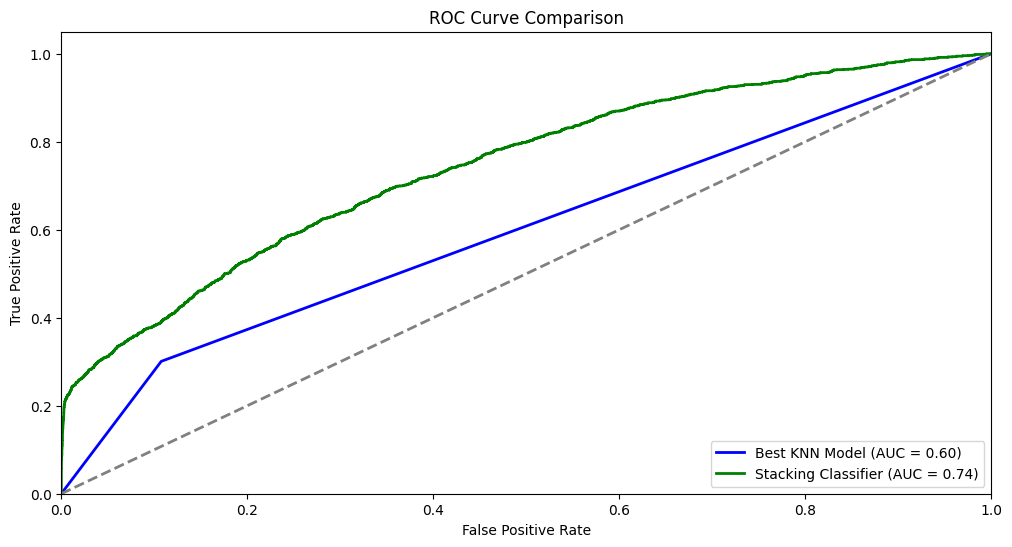

In [20]:

# Ensure that the data is in DataFrame format
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

# Best KNN Model
best_knn_params = {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 30}
best_knn = KNeighborsClassifier(**best_knn_params)

pipeline_knn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('knn', best_knn)
])

pipeline_knn.fit(X_train_df, y_train_np)
y_pred_proba_best_knn = pipeline_knn.predict_proba(X_test_df)[:, 1]

# Stacking Classifier
stacking_classifier = StackingClassifier(
    estimators=[
        ('knn', best_knn),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True))
    ],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True),
    passthrough=True,
    cv=3
)

stacking_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('to_array', FunctionTransformer(lambda x: np.asarray(x) if isinstance(x, np.matrix) else x, accept_sparse=True)),
    ('stacking', stacking_classifier)
])

stacking_pipeline.fit(X_train_df, y_train_np)
y_pred_proba_stacking = stacking_pipeline.predict_proba(X_test_df)[:, 1]

# Compute ROC curve and ROC area for each model
fpr_knn, tpr_knn, _ = roc_curve(y_test_np, y_pred_proba_best_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_stacking, tpr_stacking, _ = roc_curve(y_test_np, y_pred_proba_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

# Plotting the ROC Curves
plt.figure(figsize=(12, 6))

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Best KNN Model (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_stacking, tpr_stacking, color='green', lw=2, label=f'Stacking Classifier (AUC = {roc_auc_stacking:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


### Precision-Recall Comparison

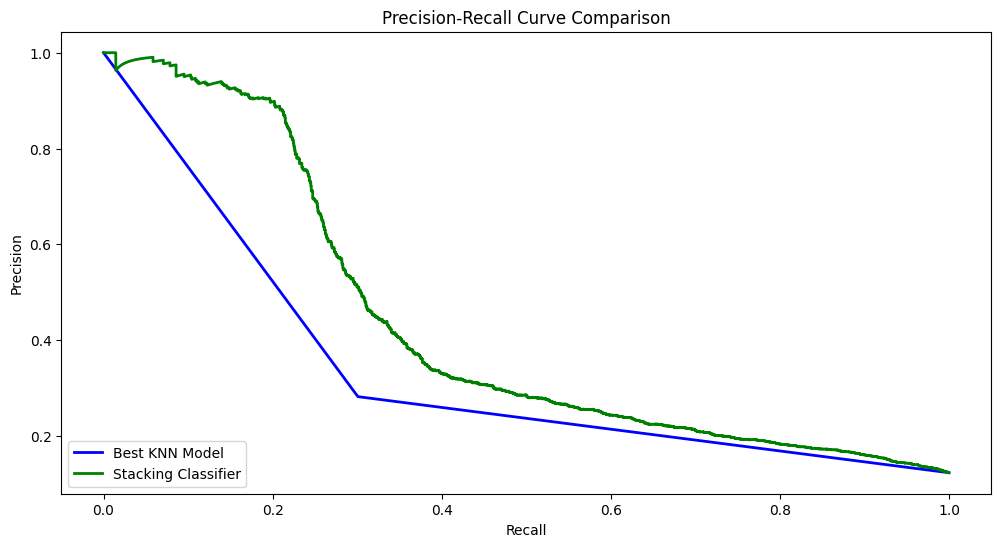

In [23]:

# Compute Precision-Recall curve and Precision-Recall area for each model
precision_knn, recall_knn, _ = precision_recall_curve(y_test_np, y_pred_proba_best_knn)
precision_stacking, recall_stacking, _ = precision_recall_curve(y_test_np, y_pred_proba_stacking)

# Plotting the Precision-Recall Curves
plt.figure(figsize=(12, 6))

plt.plot(recall_knn, precision_knn, color='blue', lw=2, label='Best KNN Model')
plt.plot(recall_stacking, precision_stacking, color='green', lw=2, label='Stacking Classifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="lower left")
plt.show()
